# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [4]:
condition_key = 'condition'
cell_type_key = 'final_annotation'
target_conditions = []


trvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

## Download Dataset and split into reference dataset and query dataset

In [5]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_labels = source_adata.obs[cell_type_key].unique().tolist()

In [6]:
source_adata

AnnData object with n_obs × n_vars = 20522 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [7]:
target_adata

AnnData object with n_obs × n_vars = 0 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

## Create TRVAE model and train it on reference dataset

In [8]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
    use_mmd=False,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [9]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██------------------| 14.0%  - epoch_loss: 3388.95 - epoch_recon_loss: 3383.05 - epoch_kl_loss:   17.08 - val_loss: 3957.06 - val_recon_loss: 3950.96 - val_kl_loss:   17.67
ADJUSTED LR
 |███-----------------| 17.2%  - epoch_loss: 3394.61 - epoch_recon_loss: 3387.77 - epoch_kl_loss:   16.09 - val_loss: 4261.39 - val_recon_loss: 4254.30 - val_kl_loss:   16.68
ADJUSTED LR
 |███-----------------| 18.6%  - epoch_loss: 3387.19 - epoch_recon_loss: 3379.92 - epoch_kl_loss:   15.81 - val_loss: 4071.28 - val_recon_loss: 4063.82 - val_kl_loss:   16.21
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 71


## Create anndata file of latent representation and compute UMAP

In [10]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['celltype'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

... storing 'celltype' as categorical
... storing 'batch' as categorical


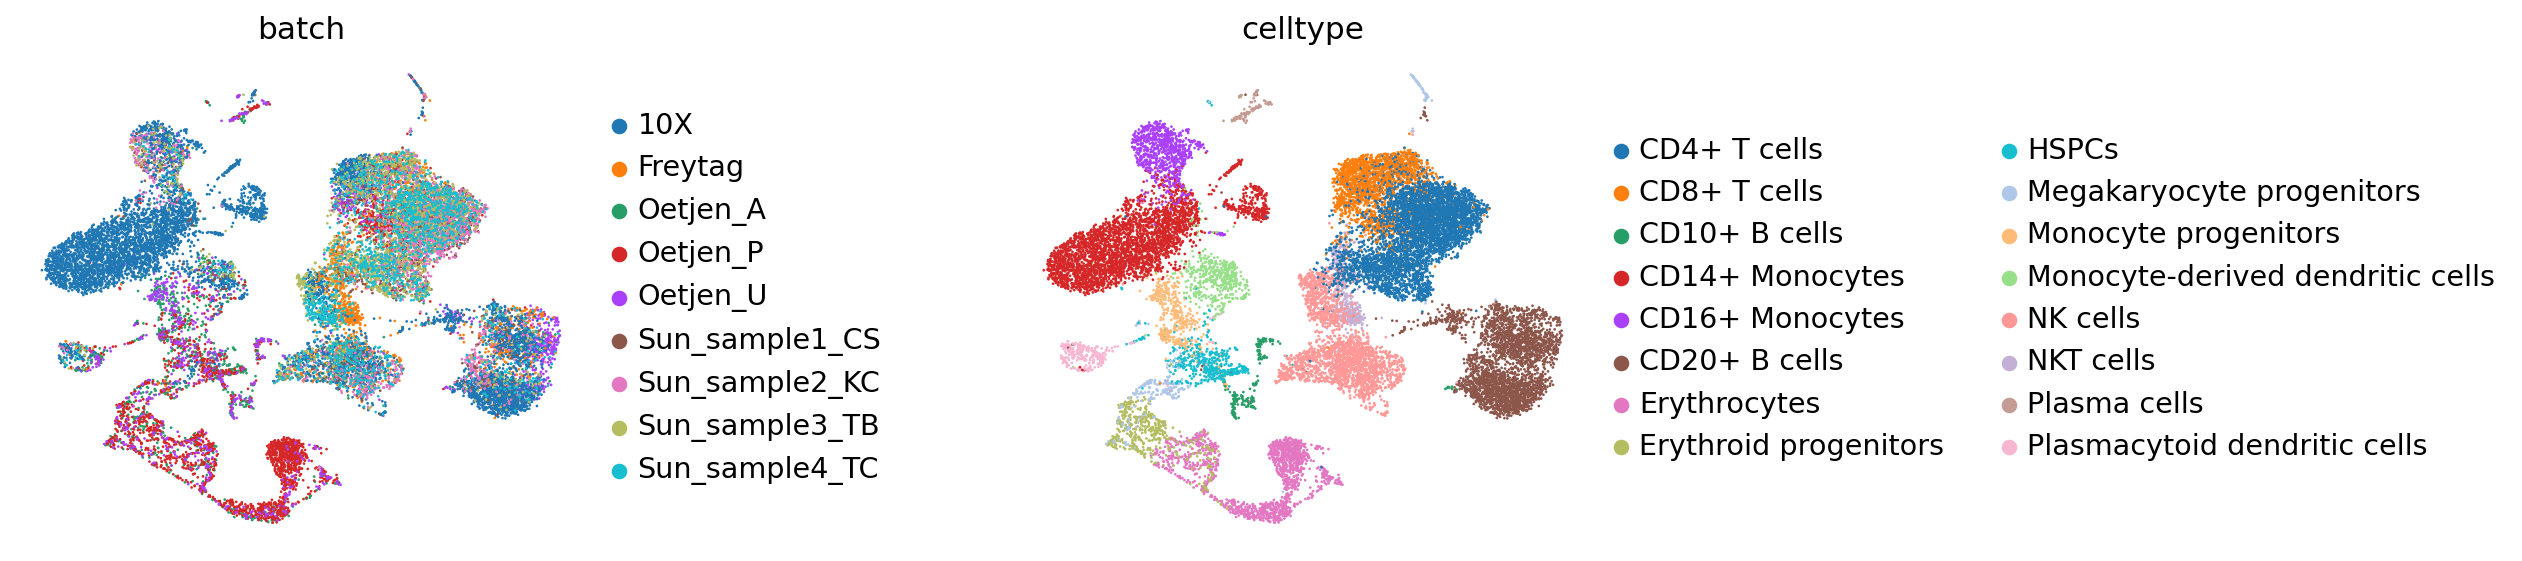

In [11]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [12]:
ref_path = 'reference_model_pbmc'
torch.save(trvae.model.state_dict(),ref_path)